In [1]:
cd modules

/home/dadmaan/Documents/dev/py_music/genre_classifier/modules


In [2]:
import os
import datetime

import utils
import helper
from helper import Metrics
from genre_classifier_m3 import DNNModel
import IPython.display as ipd

import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer

# %load_ext tensorboard
import tensorflow as tf
import tensorflow_datasets as tfds
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [3]:
# Dataset
DIR = '/run/media/dadmaan/Seagate Backup Plus Drive/datasets/'
AUDIO = os.path.join(DIR, 'fma/fma_small')
METADATA = os.path.join(DIR, 'fma/fma_metadata')

# Training
DS_TRAIN = 6400
DS_VALID = 800
DS_TEST = 800

EPOCHS = 40
BATCH_SIZE = 64
SHUFFLE_SIZE = 2 * BATCH_SIZE
STEPS_TRAIN = DS_TRAIN / BATCH_SIZE
STEPS_VALID = DS_VALID / BATCH_SIZE
STEPS_TEST = DS_TEST / BATCH_SIZE

## Data-set Prepration

In [4]:
tracks = utils.load(os.path.join(METADATA, 'tracks.csv'))
features = utils.load(os.path.join(METADATA, 'features.csv'))
genres = utils.load(os.path.join(METADATA, 'genres.csv'))

small = tracks['set', 'subset'] <= 'small'
train = tracks['set', 'split'] == 'training'
valid = tracks['set', 'split'] == 'validation'
test = tracks['set', 'split'] == 'test'

y_train = LabelBinarizer().fit_transform(tracks.loc[small & train, ('track', 'genre_top')])
y_train = pd.DataFrame(y_train, index=tracks.loc[small & train, ('track', 'genre_top')].index)
y_valid = LabelBinarizer().fit_transform(tracks.loc[small & valid, ('track', 'genre_top')])
y_valid = pd.DataFrame(y_valid , index=tracks.loc[small & valid, ('track', 'genre_top')].index)
y_test = LabelBinarizer().fit_transform(tracks.loc[small & test, ('track', 'genre_top')])
y_test = pd.DataFrame(y_test , index=tracks.loc[small & test, ('track', 'genre_top')].index)

X_train = features.loc[small & train, ('chroma_cqt','mean')]
X_valid = features.loc[small & valid, ('chroma_cqt','mean')]
X_test = features.loc[small & test, ('chroma_cqt','mean')]

print('{} features, {} classes'.format(X_train.shape[1], y_train.shape[1]))

12 features, 8 classes


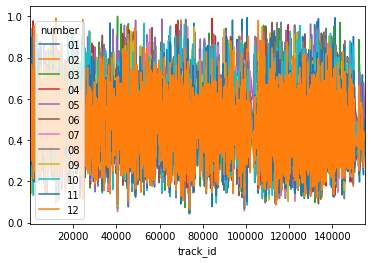

In [5]:
X_train.plot()

In [6]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))

X_valid = np.array(X_valid)
y_valid = np.array(y_valid)
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
y_valid = np.reshape(y_valid, (y_valid.shape[0], y_valid.shape[1], 1))

X_test = np.array(X_test)
y_test = np.array(y_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_test = np.reshape(y_test, (y_test.shape[0], y_test.shape[1], 1))

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((6400, 12, 1), (6400, 8, 1), (800, 12, 1), (800, 8, 1))

In [7]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid,))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [8]:
train_data = train_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).repeat()

valid_data = valid_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE).repeat()

test_data = test_data.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

train_data, valid_data, test_data

(<RepeatDataset shapes: ((None, 12, 1), (None, 8, 1)), types: (tf.float64, tf.int64)>,
 <RepeatDataset shapes: ((None, 12, 1), (None, 8, 1)), types: (tf.float64, tf.int64)>,
 <PrefetchDataset shapes: ((None, 12, 1), (None, 8, 1)), types: (tf.float64, tf.int64)>)

## Model Prepration

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 12, 1)]           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 12, 1)             4         
_________________________________________________________________
lstm1 (LSTM)                 (None, 12, 512)           1052672   
_________________________________________________________________
lstm2 (LSTM)                 (None, 12, 512)           2099200   
_________________________________________________________________
lstm3 (LSTM)                 (None, 12, 512)           2099200   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 512)           2048      
_________________________________________________________________
fc1 (Dense)                  (None, 12, 1024)          525312

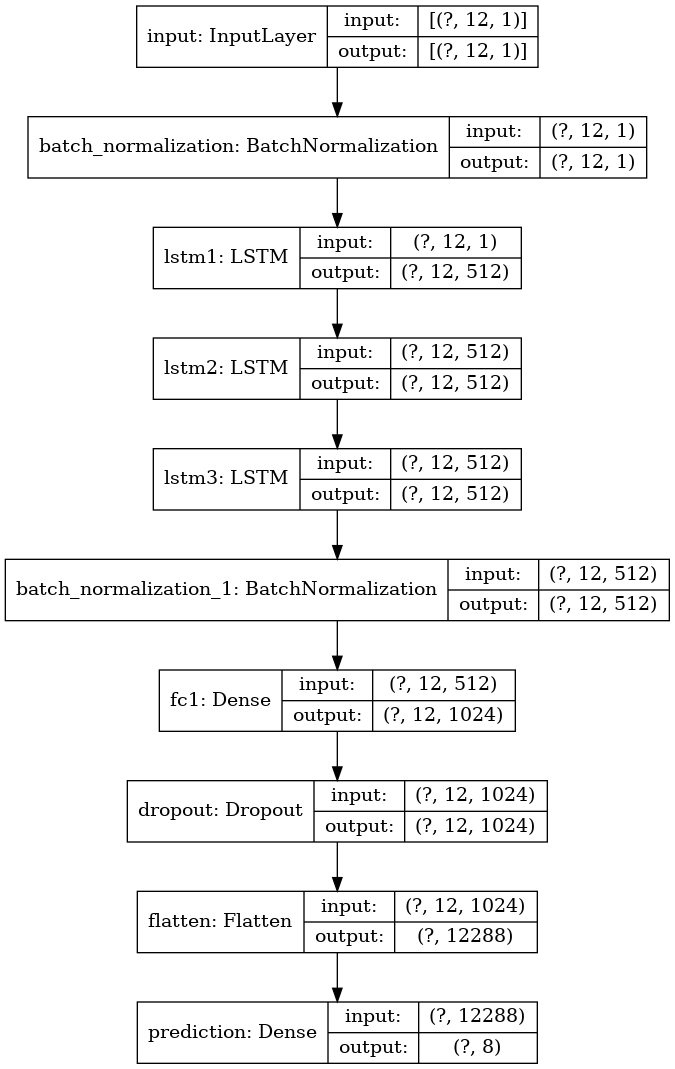

In [9]:
model = DNNModel(input_shape = (X_train.shape[1], 1), n_classes = y_train.shape[1])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()
tf.keras.utils.plot_model(model, to_file='../visualization/genre_classifier_chroma_cqt_m3.png', 
                          show_shapes=True, 
                          show_layer_names=True)

## Load Weights

In [9]:
weights_path = '../weights/exp3_1_gc_weights.hdf5'
if os.path.exists(weights_path):
    model.load_weights(weights_path, by_name=False)
    print('Weights Loaded!')

Weights Loaded!


## Callbacks

In [10]:
filepath = "../weights/exp3_1_gc_improvement_{epoch:02d}_{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    save_weights_only=True,
    mode='min'
)

# Due to some issue, Tensorboard can't work in Anaconda environment
# log_dir = "logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard = tf.keras.callbacks.TensorBoard(
#     log_dir='log_dir', histogram_freq=1, write_graph=True, write_images=True,
#     update_freq='epoch', profile_batch=2, embeddings_freq=0,
#     embeddings_metadata=None
# )

# To evaluate the f1-score, we need the labels have a same shape as model predicts
y_valid = np.reshape(y_valid, (y_valid.shape[0], y_valid.shape[1]))
validation_data = [X_valid, y_valid]
f1_score = Metrics(validation_data)

callbacks_list = [checkpoint, f1_score]

## Train Model

Train for 100.0 steps, validate for 12.5 steps
Epoch 1/40
100/100 [==============================] - 207s 2s/step - loss: 1.9863 - accuracy: 0.2239 - val_loss: 2.1633 - val_accuracy: 0.1250


/home/dadmaan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
/home/dadmaan/.local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Epoch 2/40
100/100 [==============================] - 179s 2s/step - loss: 1.9663 - accuracy: 0.2414 - val_loss: 2.1614 - val_accuracy: 0.1250
Epoch 3/40
100/100 [==============================] - 170s 2s/step - loss: 1.9532 - accuracy: 0.2470 - val_loss: 2.1587 - val_accuracy: 0.1325
Epoch 4/40
100/100 [==============================] - 170s 2s/step - loss: 1.9525 - accuracy: 0.2377 - val_loss: 2.1382 - val_accuracy: 0.1963
Epoch 5/40
100/100 [==============================] - 177s 2s/step - loss: 1.9331 - accuracy: 0.2491 - val_loss: 2.1169 - val_accuracy: 0.1775
Epoch 6/40
100/100 [==============================] - 173s 2s/step - loss: 1.9376 - accuracy: 0.2481 - val_loss: 2.0771 - val_accuracy: 0.2325
Epoch 7/40
100/100 [==============================] - 162s 2s/step - loss: 1.9255 - accuracy: 0.2581 - val_loss: 2.0624 - val_accuracy: 0.2200
Epoch 8/40
100/100 [==============================] - 163s 2s/step - loss: 1.9346 - accuracy: 0.2553 - val_loss: 2.0722 - val_accuracy: 0.2288

AttributeError: 'dict' object has no attribute 'columns'

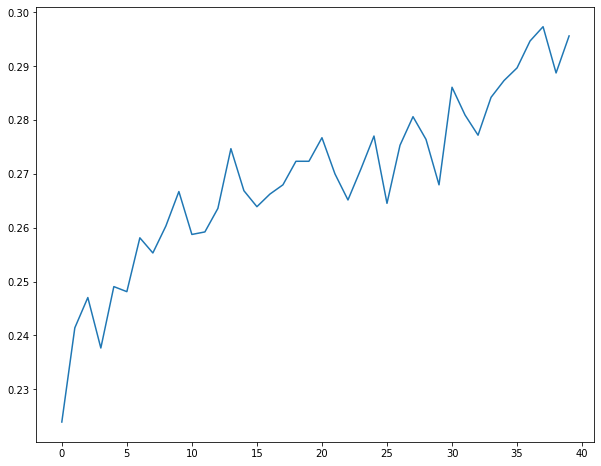

In [11]:
history = model.fit(train_data, 
                    epochs=EPOCHS, 
                    steps_per_epoch=STEPS_TRAIN,
                    validation_data=valid_data,
                    validation_steps=STEPS_VALID,
                    callbacks=callbacks_list)

helper.save_training_history('../logs/exp3_1_logs', history.history, f1_score.val_f1s)

In [18]:
model.save_weights('../weights/exp3_1_gc_weights.hdf5')
print('Weights Saved!')

Weights Saved!


## Plot Training Results

## Evaluate Model

In [19]:
results = model.evaluate(test_data, steps=STEPS_TEST)
evaluation = pd.DataFrame(results)
evaluation.to_csv('../logs/exp3_1_evaluation_log.csv', index=False)

13/12 [===============================] - 5s 384ms/step - loss: 1.9755 - accuracy: 0.2262


## Predictions

In [ ]:
predictions = model.predict(test_data)

In [ ]:
columns = genres.reset_index().set_index('title')
columns = columns.loc[tracks.loc[small, ('track', 'genre_top')].unique()]

In [ ]:
pred = pd.DataFrame(data=predictions[0:, 0:],
            columns=columns.index.values)
pred.to_csv('../metrics/exp2_predictions.csv', index=False)

In [ ]:
pred > 0.5